In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Fitzpatrick17k

In [16]:
csv_file = '/home/ali/Datasets/Fitz17k/fitzpatrick17k.csv'
df = pd.read_csv(csv_file)
df.rename(columns={'md5hash': 'hasher'}, inplace=True)

In [17]:
# drop unknown skin type
code_df = df.loc[df['fitzpatrick_scale'] != -1].copy()

# encode disease names to numbers
code_df["low"] = code_df['label'].astype('category').cat.codes
code_df["mid"] = code_df['nine_partition_label'].astype('category').cat.codes
code_df["high"] = code_df['three_partition_label'].astype('category').cat.codes

labellist = code_df['three_partition_label'].values.tolist()
labels = [1 if x == 'malignant' else 0 for x in labellist]
code_df["binary"] = labels

# adding fitzpatrick columns
def map_fitzpatrick(value):
    # Map values 1, 2, 3 to 0, and 4, 5, 6 to 1
    return 0 if value in [1, 2, 3] else 1
            
code_df['fitzpatrick_binary'] = code_df['fitzpatrick_scale'].apply(map_fitzpatrick)
code_df['fitzpatrick'] = code_df['fitzpatrick_scale'] - 1


In [18]:
'''
calculate weights for each skin type and condition
method 1 reweighting
'''
level = 'high'
total = code_df['fitzpatrick_scale'].count()  # total samples
type_count = code_df['fitzpatrick_scale'].value_counts().sort_index()
condition_count = code_df[level].value_counts().sort_index()
print(total)
print(type_count)
print(type_count[1])
print(condition_count)
weight_record = np.zeros((7, 3))
num_record = np.zeros((7, 3))
for i in range(1, 7): # skin type
    for j in range(len(condition_count)): # skin condition
        x = code_df.loc[(code_df['fitzpatrick_scale']==i) & (code_df[level]==j)]
        num_record[i, j] = len(x)
        # print('joint num', len(x))
        weight = type_count[i]*condition_count[j]/(len(x)*total)
        # print('weight', weight)
        weight_record[i, j] = weight
print(weight_record)
print(num_record)
# add weights to the csv file
weight_list = []  # weight for each sample in the code_df
for k in range(total):
    row_data = code_df.iloc[k]
    # print(row_data)
    weight_list.append(weight_record[int(row_data['fitzpatrick_scale']), int(row_data[level])])
    # print(weight_list)
print(len(weight_list))
code_df['REWT_weights'] = weight_list

16012
fitzpatrick_scale
1    2947
2    4808
3    3308
4    2781
5    1533
6     635
Name: count, dtype: int64
2947
high
0     2160
1     2160
2    11692
Name: count, dtype: int64
[[0.         0.         0.        ]
 [0.89537577 0.87758684 1.0497104 ]
 [0.96660738 0.8741153  1.03411278]
 [0.93946382 0.97860815 1.01620083]
 [1.02221699 1.24635759 0.9610472 ]
 [1.3006283  1.40680204 0.9123066 ]
 [1.94683533 1.40427466 0.87486508]]
[[   0.    0.    0.]
 [ 444.  453. 2050.]
 [ 671.  742. 3395.]
 [ 475.  456. 2377.]
 [ 367.  301. 2113.]
 [ 159.  147. 1227.]
 [  44.   61.  530.]]
16012


In [19]:
'''
calculate weights for each skin type and condition
method 2 resampling   weight=1/num
'''
level = 'high'
total = code_df['fitzpatrick_scale'].count()  # total samples
type_count = code_df['fitzpatrick_scale'].value_counts().sort_index()
condition_count = code_df[level].value_counts().sort_index()
weight_record = np.zeros((7, 3))
num_record = np.zeros((7, 3))
for i in range(1, 7): # skin type
    for j in range(len(condition_count)): # skin condition
        x = code_df.loc[(code_df['fitzpatrick_scale']==i) & (code_df[level]==j)]
        num_record[i, j] = len(x)
        # print('joint num', len(x))
        weight = 1/len(x)
        # print('weight', weight)
        weight_record[i, j] = weight
# print(num_record)
print(weight_record)
# add weights to the csv file
weight_list = []  # weight for each sample in the code_df
for k in range(total):
    row_data = code_df.iloc[k]
    # print(row_data)
    weight_list.append(weight_record[int(row_data['fitzpatrick_scale']), int(row_data[level])])
    # print(weight_list)
print(len(weight_list))
code_df['RESM_weights'] = weight_list

[[0.         0.         0.        ]
 [0.00225225 0.00220751 0.0004878 ]
 [0.00149031 0.00134771 0.00029455]
 [0.00210526 0.00219298 0.0004207 ]
 [0.0027248  0.00332226 0.00047326]
 [0.00628931 0.00680272 0.000815  ]
 [0.02272727 0.01639344 0.00188679]]
16012


In [20]:
code_df

,hasher,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum,low,mid,high,binary,fitzpatrick_binary,fitzpatrick,REWT_weights,RESM_weights
0,5e82a45bc5d78bd24ae9202d194423f8,3,3,drug induced pigmentary changes,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicmminoc...,20,4,2,0,0,2,1.016201,0.000421
1,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...,75,4,2,0,0,0,1.049710,0.000488
2,d2bac3c9e4499032ca8e9b07c7d3bc40,2,3,dermatofibroma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicdderma...,16,0,0,0,0,1,0.966607,0.001490
3,0a94359e7eaacd7178e06b2823777789,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,86,4,2,0,0,0,1.049710,0.000488
4,a39ec3b1f22c08a421fa20535e037bba,1,1,psoriasis,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicppsori...,86,4,2,0,0,0,1.049710,0.000488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16571,add52850b24199d9c49f2882f67c2b37,3,4,lichen amyloidosis,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=3694,httpwwwatlasdermatologicocombrimgimageId3694.jpg,47,4,2,0,0,2,1.016201,0.000421
16572,cd90e491ddaa92f0f4eb07f73aa09f64,5,5,scleroderma,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=4529,httpwwwatlasdermatologicocombrimgimageId4529.jpg,93,4,2,0,1,4,0.912307,0.000815
16573,5f1ed6de6a9110d7dc580a6a0312af63,4,5,pityriasis rosea,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=5630,httpwwwatlasdermatologicocombrimgimageId5630.jpg,79,4,2,0,1,3,0.961047,0.000473
16574,f198aaf1f0550c2464b285454d34926e,3,3,myiasis,inflammatory,non-neoplastic,NaN,http://atlasdermatologico.com.br/img?imageId=4609,httpwwwatlasdermatologicocombrimgimageId4609.jpg,61,4,2,0,0,2,1.016201,0.000421


In [21]:
new_path = '/home/ali/Datasets/Fitz17k/fitzpatrick17k_preprocessed.csv'
code_df.to_csv(new_path, index=False)

In [22]:
# connect class number and class name
connection = {}
name_list = {'low':'label', 'mid':'nine_partition_label', 'high':'three_partition_label'}
connection['low'] = [0]*114
connection['mid'] = [0]*9
connection['high'] = [0]*3
for label in ['low', 'mid', 'high']:
    for i in range(len(connection[label])):
        capture = code_df.loc[code_df[label]==i].iloc[0][name_list[label]]
        connection[label][i] = capture
print(connection)

{'low': ['acanthosis nigricans', 'acne', 'acne vulgaris', 'acquired autoimmune bullous diseaseherpes gestationis', 'acrodermatitis enteropathica', 'actinic keratosis', 'allergic contact dermatitis', 'aplasia cutis', 'basal cell carcinoma', 'basal cell carcinoma morpheiform', 'becker nevus', 'behcets disease', 'calcinosis cutis', 'cheilitis', 'congenital nevus', 'dariers disease', 'dermatofibroma', 'dermatomyositis', 'disseminated actinic porokeratosis', 'drug eruption', 'drug induced pigmentary changes', 'dyshidrotic eczema', 'eczema', 'ehlers danlos syndrome', 'epidermal nevus', 'epidermolysis bullosa', 'erythema annulare centrifigum', 'erythema elevatum diutinum', 'erythema multiforme', 'erythema nodosum', 'factitial dermatitis', 'fixed eruptions', 'folliculitis', 'fordyce spots', 'granuloma annulare', 'granuloma pyogenic', 'hailey hailey disease', 'halo nevus', 'hidradenitis', 'ichthyosis vulgaris', 'incontinentia pigmenti', 'juvenile xanthogranuloma', 'kaposi sarcoma', 'keloid', 'k

In [23]:
'''
Look into Derm/Atla
'''
derm = code_df.loc[code_df.url.str.contains("dermaamin")==False]
value_counts = derm['low'].value_counts()
value_counts = value_counts.rename_axis('unique_values').reset_index(name='counts')
print(value_counts)
final_set = set((value_counts.loc[value_counts['counts']>1])['unique_values'])
print(len(final_set))

    unique_values  counts
0               8     253
1              48     225
2              98     196
3              80     172
4              92     126
..            ...     ...
87             74       2
88             77       2
89             72       2
90             24       2
91             53       1

[92 rows x 2 columns]
91


fitzpatrick_scale
2    4137
1    2780
3    2298
4    1689
5     891
6     427
Name: count, dtype: int64


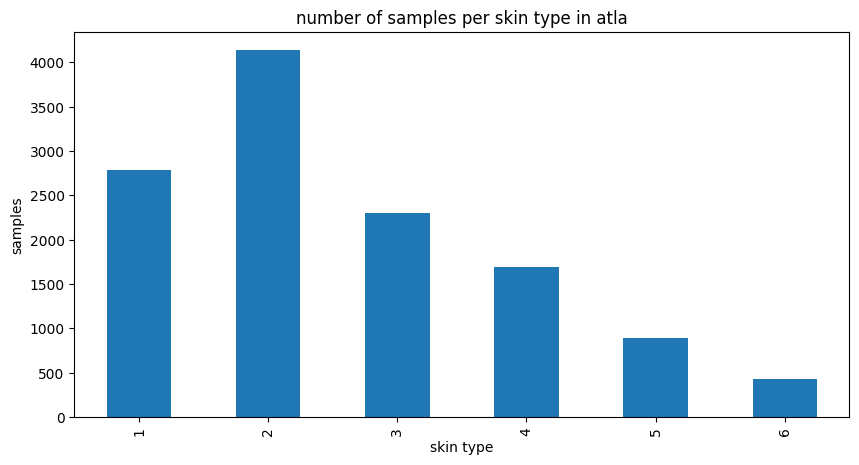

In [24]:
'''
Visualize data distribution
'''
plt.figure(figsize=(10,5))
type = code_df['fitzpatrick_scale']
# for derm
derm = code_df.loc[code_df.url.str.contains("dermaamin")==True]
type = derm['fitzpatrick_scale']
print(type.value_counts())
type.value_counts().sort_index().plot.bar()
plt.xlabel('skin type')
plt.ylabel('samples')
plt.title('number of samples per skin type in atla')
# plt.savefig(fig_folder+'skin_type_statistics.jpg')
plt.show()

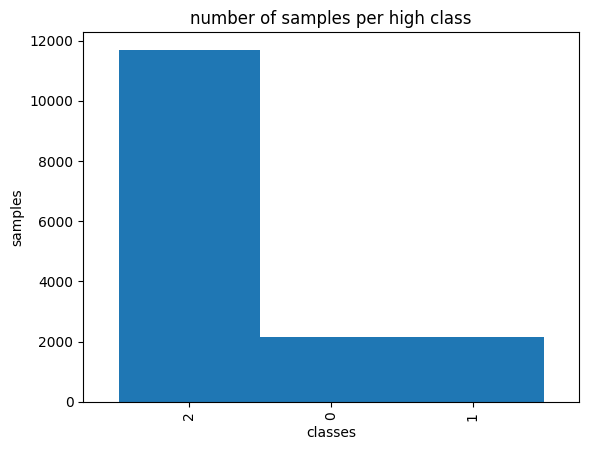

In [11]:
'''
Visualize Skin type distribution
'''
# count number of samples for each skin condition
# plt.figure(figsize=(25, 5), dpi=200)
plt.figure()
phase = 'high'
label = code_df[phase]
label.value_counts().plot.bar(width=1)
# plt.hist(count_condition.values, bins=200)
# plt.title('Histogram age_approx counts in train')
plt.xlabel('classes')
plt.ylabel('samples')
# plt.xticks([])
plt.title('number of samples per {} class'.format(phase))
plt.show()
# print(count_condition)

# HIBA

In [16]:
df = pd.read_csv('/home/ali/Datasets/HIBA/hospital-italiano-de-buenos-aires-skin-lesions-images-2019-2022_metadata_2023-12-14.csv')
supp_data = pd.read_csv('/home/ali/Datasets/HIBA/SupplementaryData.csv')
df = df.merge(supp_data, on='isic_id')

In [17]:
# drop unknown skin type
df = df.rename(columns={'skin_type': 'fitzpatrick_scale', 'isic_id': 'hasher'})
df = df.dropna(subset='fitzpatrick_scale').copy()

# dropping lichenoid keratosis because the numberof samples is too low
df = df.drop(df[df['diagnosis'] == 'lichenoid keratosis'].index)

# encode disease names to numbers
df["low"] = df['diagnosis'].astype('category').cat.codes
df["binary"] = df['benign_malignant'].apply(lambda x: 1 if x == 'malignant' else 0)


# adding fitzpatrick columns
def map_fitzpatrick(value):
    # Map values 1, 2, 3 to 0, and 4, 5, 6 to 1
    return 0 if value in [1, 2, 3] else 1
df['fitzpatrick_scale'] = df['fitzpatrick_scale'].apply({'I': 1, 'II': 2, 'III': 3, 'IV': 4, 'V': 5, 'VI': 6}.get)
df['fitzpatrick_binary'] = df['fitzpatrick_scale'].apply(map_fitzpatrick)
df['fitzpatrick'] = df['fitzpatrick_scale'] - 1


In [18]:
df.to_csv('/home/ali/Datasets/HIBA/HIBA.csv', index=False)

# PAD-UFES-20

In [39]:
df = pd.read_csv('/home/ali/Datasets/PAD-UFES-20/metadata.csv')
df

,patient_id,lesion_id,smoke,drink,background_father,background_mother,age,pesticide,gender,skin_cancer_history,...,diameter_2,diagnostic,itch,grew,hurt,changed,bleed,elevation,img_id,biopsed
0,PAT_1516,1765,NaN,NaN,NaN,NaN,8,NaN,NaN,NaN,...,NaN,NEV,False,False,False,False,False,False,PAT_1516_1765_530.png,False
1,PAT_46,881,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,5.0,BCC,True,True,False,True,True,True,PAT_46_881_939.png,True
2,PAT_1545,1867,NaN,NaN,NaN,NaN,77,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1545_1867_547.png,False
3,PAT_1989,4061,NaN,NaN,NaN,NaN,75,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1989_4061_934.png,False
4,PAT_684,1302,False,True,POMERANIA,POMERANIA,79,False,MALE,True,...,5.0,BCC,True,True,False,False,True,True,PAT_684_1302_588.png,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2293,PAT_1708,3156,NaN,NaN,NaN,NaN,73,NaN,NaN,NaN,...,NaN,ACK,True,False,False,False,False,False,PAT_1708_3156_175.png,False
2294,PAT_46,880,False,False,POMERANIA,POMERANIA,55,False,FEMALE,True,...,12.0,BCC,True,True,False,True,False,False,PAT_46_880_140.png,True
2295,PAT_1343,1217,NaN,NaN,NaN,NaN,74,NaN,NaN,NaN,...,NaN,SEK,False,False,False,False,False,False,PAT_1343_1217_404.png,False
2296,PAT_326,690,False,False,POMERANIA,POMERANIA,58,True,FEMALE,True,...,4.0,BCC,True,False,False,False,False,True,PAT_326_690_823.png,True


In [40]:
# drop unknown skin type
df = df.rename(columns={'fitspatrick': 'fitzpatrick_scale', 'img_id': 'hasher'})
df = df.dropna(subset='fitzpatrick_scale').copy()
df['fitzpatrick_scale'] = df['fitzpatrick_scale'].astype(int)

#Drop skin type 6, since it only contains one record
df = df.drop(df[df['fitzpatrick_scale'] == 6].index)

# encode disease names to numbers
df["low"] = df['diagnostic'].astype('category').cat.codes

# adding fitzpatrick columns
def map_fitzpatrick(value):
    # Map values 1, 2, 3 to 0, and 4, 5, 6 to 1
    return 0 if value in [1, 2, 3] else 1
df['fitzpatrick_binary'] = df['fitzpatrick_scale'].apply(map_fitzpatrick)
df['fitzpatrick'] = df['fitzpatrick_scale'] - 1

In [41]:
df.to_csv('/home/ali/Datasets/PAD-UFES-20/PAD-UFES-20.csv', index=False)